E:\Anaconda\lib\site-packages\sklearn\model_selection\_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


Best hyperparameters found by grid search: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 150}
Therefore, the above mentioned hyperparameters will be used for the RF classifier


C:\Users\Ocpal\AppData\Local\Temp\ipykernel_17000\3015822605.py:66: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train_test_pca[:len(X_train_scaled), :], y_train)


Accuracy on PCA Embedded Test Data: 55.57%
Confusion matrix:
 [[429   3  64   0   0   0   0   0   0   0   0   0]
 [ 61 365  44   0   0   0   1   0   0   0   0   0]
 [189  55 176   0   0   0   0   0   0   0   0   0]
 [  0   0   0 122 311  74   0   0   0   0   1   0]
 [  0   3   0  45 471  37   0   0   0   0   0   0]
 [  0   2   0 132 247 164   0   0   0   0   0   0]
 [  0   8   0   0   1   2   0   0   7   1   3   1]
 [  0   1   0   0   0   1   0   3   2   1   0   2]
 [  0   5   0   0   0   0   3   2   6   4  10   2]
 [  0   1   0   0   0   0   0   1   7   7   5   4]
 [  0  19   0   0   1   0   2   0   6   7  12   2]
 [  0   3   0   0   0   0   0   3   7   3   9   2]]


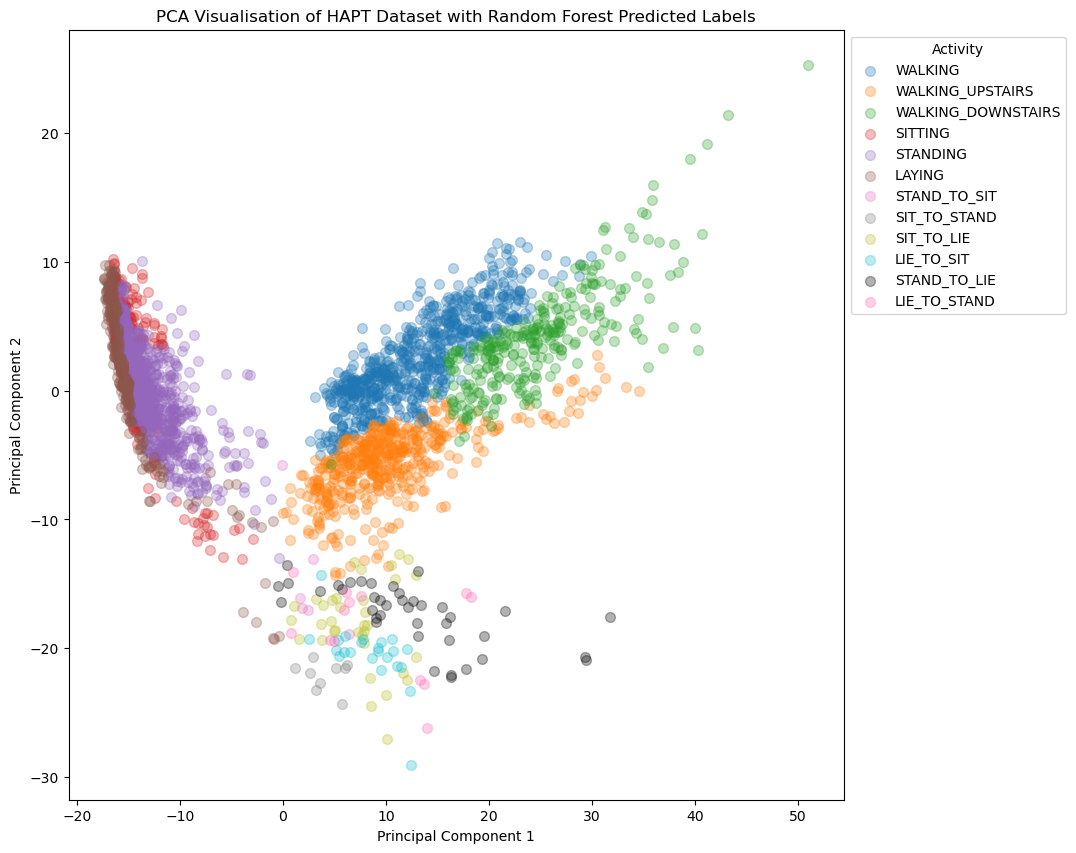

In [5]:
# Imports required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.model_selection import GridSearchCV, cross_val_score

# Defines a function for filtering data
def filter_data(data):
    filtered_data = data
    return filtered_data

# Load the training and testing data
X_train = pd.read_csv('E:/HAPT/Train/X_train.txt', delim_whitespace=True, header=None)
y_train = pd.read_csv('E:/HAPT/Train/y_train.txt', delim_whitespace=True, header=None)
X_test = pd.read_csv('E:/HAPT/Test/X_test.txt', delim_whitespace=True, header=None)
y_test = pd.read_csv('E:/HAPT/Test/y_test.txt', delim_whitespace=True, header=None)

# Load the subject IDs and activity labels
train_subjects = pd.read_csv('E:/HAPT/Train/subject_id_train.txt', header=None)
test_subjects = pd.read_csv('E:/HAPT/Test/subject_id_test.txt', header=None)
activity_labels = pd.read_csv('E:/HAPT/activity_labels.txt', delim_whitespace=True, header=None, index_col=0).reset_index()

# Scale the training data using StandardScaler
scaler = StandardScaler()
# Scale the training data using StandardScaler
X_train_scaled = scaler.fit_transform(X_train)

# Filter the test data using the filter_data function
X_test_filtered = filter_data(X_test)

# Scale the filtered test data using the same StandardScaler object
X_test_scaled = scaler.transform(X_test_filtered)

# Apply PCA to reduce the dimensionality of the data
pca = PCA(n_components=2, random_state=42)
X_train_test_pca = pca.fit_transform(np.vstack((X_train_scaled, X_test_scaled)))
X_test_pca = X_train_test_pca[len(X_train_scaled):, :]

# Define the parameter grid for Random Forest
param_grid = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [10, 20, 30, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Build a Random Forest classifier
rf = RandomForestClassifier(random_state=42)

# Perform a grid search to find the best hyperparameters
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train_test_pca[:len(X_train_scaled), :], y_train)

# Print the best hyperparameters found by the grid search
print("Best hyperparameters found by grid search:", grid_search.best_params_)
print("Therefore, the above mentioned hyperparameters will be used for the RF classifier")

# Train the Random Forest with the best hyperparameters on the entire training set
rf = grid_search.best_estimator_
rf.fit(X_train_test_pca[:len(X_train_scaled), :], y_train)

# Evaluate the model on the test set using accuracy score and confusion matrix
y_pred = rf.predict(X_test_pca)
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Accuracy on PCA Embedded Test Data: {:.2f}%".format(accuracy*100))
print("Confusion matrix:\n", conf_matrix)

df = pd.DataFrame(X_test_pca, columns=['PC1', 'PC2'])
df['true_label'] = y_test
df['predicted_label'] = y_pred
df['subject_id'] = test_subjects

# Set the list of colors to use
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#000000', '#ff69b4']

# Create a scatter plot of the PCA embeddings
fig, ax = plt.subplots(figsize=(10, 10))
for i, row in activity_labels.iterrows():
    # Get the activity label
    activity = row[0]
    # Get the activity name
    activity_name = row[1]
    activity_df = df[df['predicted_label'] == activity]
    # Cycle through the colors
    color = colors[i % len(colors)]  
    ax.scatter(activity_df['PC1'], activity_df['PC2'], c=[color], alpha=0.3, s=50, label=activity_name)

# Adds title to the plot
ax.set_title("PCA Visualisation of HAPT Dataset with Random Forest Predicted Labels")
# Adds legend to the plot
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Activity')
# Set X and Y axis labels
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
# Shows the plot
plt.show()